## Install Packages

In [151]:
!pip install bitsandbytes --quiet

## Imports

In [ ]:
from datasets import DatasetDict
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import os
import pandas as pd
import torch
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score
from transformers import AutoTokenizer, AutoModelForTextEncoding


## Set Seed

In [153]:
SEED = 42

## Load Data

In [154]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [155]:
DEVICE

device(type='cuda')

In [156]:
DATA_PATH = "/kaggle/input/datasets/bingxuanchia/dreaddit-dataset"
train_df = pd.read_csv(os.path.join(DATA_PATH, "dreaddit-train.csv"))
test_df = pd.read_csv(os.path.join(DATA_PATH, "dreaddit-test.csv"))

In [157]:
train_df.head()

,subreddit,post_id,sentence_range,text,id,label,confidence,social_timestamp,social_karma,syntax_ari,...,lex_dal_min_pleasantness,lex_dal_min_activation,lex_dal_min_imagery,lex_dal_avg_activation,lex_dal_avg_imagery,lex_dal_avg_pleasantness,social_upvote_ratio,social_num_comments,syntax_fk_grade,sentiment
0,ptsd,8601tu,"(15, 20)","He said he had not felt that way before, sugge...",33181,1,0.8,1521614353,5,1.806818,...,1.000,1.1250,1.0,1.77000,1.52211,1.89556,0.86,1,3.253573,-0.002742
1,assistance,8lbrx9,"(0, 5)","Hey there r/assistance, Not sure if this is th...",2606,0,1.0,1527009817,4,9.429737,...,1.125,1.0000,1.0,1.69586,1.62045,1.88919,0.65,2,8.828316,0.292857
2,ptsd,9ch1zh,"(15, 20)",My mom then hit me with the newspaper and it s...,38816,1,0.8,1535935605,2,7.769821,...,1.000,1.1429,1.0,1.83088,1.58108,1.85828,0.67,0,7.841667,0.011894
3,relationships,7rorpp,"[5, 10]","until i met my new boyfriend, he is amazing, h...",239,1,0.6,1516429555,0,2.667798,...,1.000,1.1250,1.0,1.75356,1.52114,1.98848,0.50,5,4.104027,0.141671
4,survivorsofabuse,9p2gbc,"[0, 5]",October is Domestic Violence Awareness Month a...,1421,1,0.8,1539809005,24,7.554238,...,1.000,1.1250,1.0,1.77644,1.64872,1.81456,1.00,1,7.910952,-0.204167


In [158]:
test_df.head()

,id,subreddit,post_id,sentence_range,text,label,confidence,social_timestamp,social_karma,syntax_ari,...,lex_dal_min_pleasantness,lex_dal_min_activation,lex_dal_min_imagery,lex_dal_avg_activation,lex_dal_avg_imagery,lex_dal_avg_pleasantness,social_upvote_ratio,social_num_comments,syntax_fk_grade,sentiment
0,896,relationships,7nu7as,"[50, 55]","Its like that, if you want or not.“ ME: I have...",0,0.8,1.514981e+09,22,-1.238793,...,1.0000,1.2000,1.0,1.65864,1.32245,1.80264,0.63,62,-0.148707,0.000000
1,19059,anxiety,680i6d,"(5, 10)",I man the front desk and my title is HR Custom...,0,1.0,1.493348e+09,5,7.684583,...,1.4000,1.1250,1.0,1.69133,1.69180,1.97249,1.00,2,7.398222,-0.065909
2,7977,ptsd,8eeu1t,"(5, 10)",We'd be saving so much money with this new hou...,1,1.0,1.524517e+09,10,2.360408,...,1.1429,1.0000,1.0,1.70974,1.52985,1.86108,1.00,8,3.149288,-0.036818
3,1214,ptsd,8d28vu,"[2, 7]","My ex used to shoot back with ""Do you want me ...",1,0.5,1.524018e+09,5,5.997000,...,1.0000,1.3000,1.0,1.72615,1.52000,1.84909,1.00,7,6.606000,-0.066667
4,1965,relationships,7r1e85,"[23, 28]",I haven’t said anything to him yet because I’m...,0,0.8,1.516200e+09,138,4.649418,...,1.1250,1.1429,1.0,1.75642,1.43582,1.91725,0.84,70,4.801869,0.141667


## Check for NaN Values

In [159]:
train_df[train_df.isna().any(axis=1)]

,subreddit,post_id,sentence_range,text,id,label,confidence,social_timestamp,social_karma,syntax_ari,...,lex_dal_min_pleasantness,lex_dal_min_activation,lex_dal_min_imagery,lex_dal_avg_activation,lex_dal_avg_imagery,lex_dal_avg_pleasantness,social_upvote_ratio,social_num_comments,syntax_fk_grade,sentiment


In [160]:
test_df[test_df.isna().any(axis=1)]

,id,subreddit,post_id,sentence_range,text,label,confidence,social_timestamp,social_karma,syntax_ari,...,lex_dal_min_pleasantness,lex_dal_min_activation,lex_dal_min_imagery,lex_dal_avg_activation,lex_dal_avg_imagery,lex_dal_avg_pleasantness,social_upvote_ratio,social_num_comments,syntax_fk_grade,sentiment


## Exploratory Data Analysis

In [161]:
PLOTS_FOLDER_PATH = os.path.normpath(os.path.join(os.getcwd(), "..", "plots"))
os.makedirs(PLOTS_FOLDER_PATH, exist_ok=True)

EDA_FOLDER_PATH = os.path.normpath(os.path.join(PLOTS_FOLDER_PATH, "eda"))
os.makedirs(EDA_FOLDER_PATH, exist_ok=True)

### Stress Label Counts

In [162]:
def get_label_counts(df):
    return df["label"].value_counts()

In [163]:
get_label_counts(train_df)

label
1    1488
0    1350
Name: count, dtype: int64

In [164]:
get_label_counts(test_df)

label
1    369
0    346
Name: count, dtype: int64

### Stress Label Counts by Subreddits

In [165]:
def plot_label_counts_by_subreddit(df, df_name):
    fig, ax = plt.subplots(figsize=(10, 6))

    # grouped bar chart
    sns.countplot(
        data=df,
        x="subreddit",
        hue="label",
        order=df["subreddit"].value_counts().index
    )

    # set title, axes and legend
    plt.title(f"Stress Label Counts by Subreddit in {df_name}")
    ax.set_xlabel("Subreddit")
    ax.set_ylabel("Count")
    ax.legend(title="Label")

    # edit x axis
    plt.xticks(rotation=45)

    plt.tight_layout()

    # save plot
    plt.savefig(os.path.join(EDA_FOLDER_PATH, f"label_counts_by_subreddit_{df_name.lower()}.png"))

    plt.show()

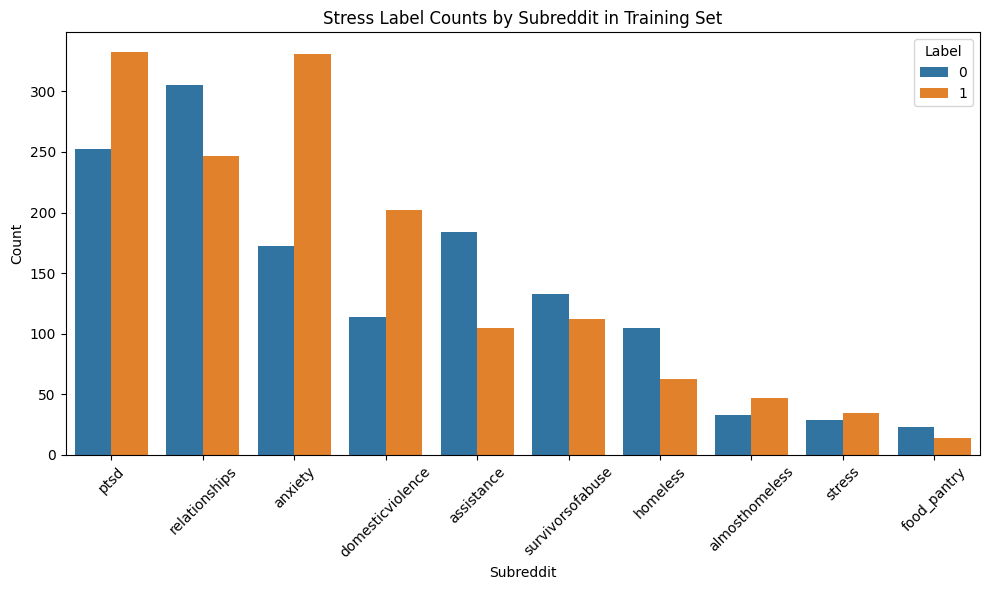

In [166]:
plot_label_counts_by_subreddit(train_df, "Training Set")

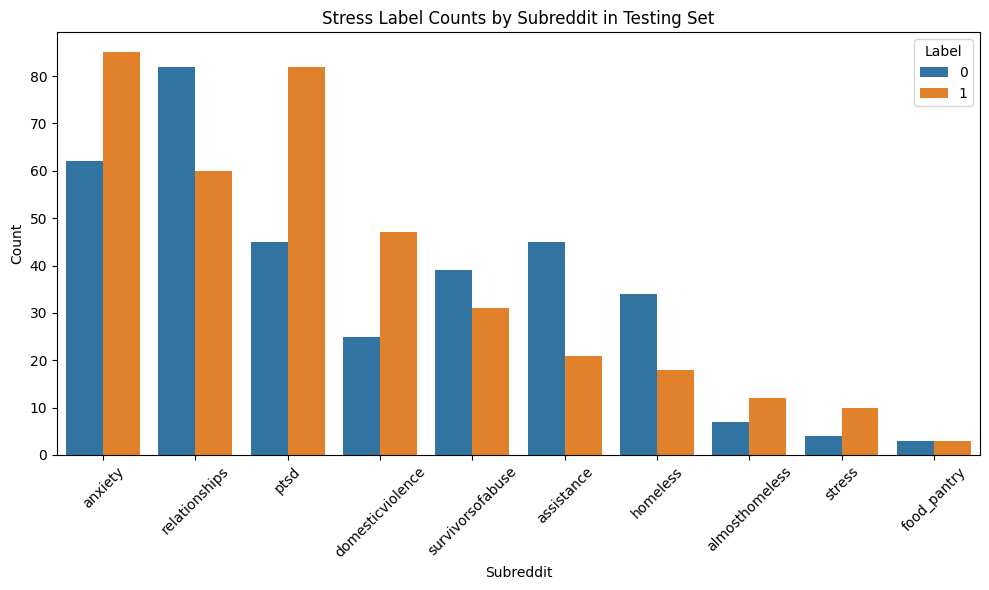

In [167]:
plot_label_counts_by_subreddit(test_df, "Testing Set")

### Text Length

In [168]:
def plot_text_length(df, df_name):
    fig, ax = plt.subplots(figsize=(10, 6))

    # histogram
    sns.histplot(df["lex_liwc_WC"], bins=40, kde=True)

    # set title and axes
    plt.title(f"Distribution of Word Count in {df_name}")
    ax.set_xlabel("Number of Words")
    ax.set_ylabel("Frequency")
    
    plt.tight_layout()

    # save plot
    plt.savefig(os.path.join(EDA_FOLDER_PATH, f"text_length_distribution_{df_name.lower()}.png"))
                
    plt.show()

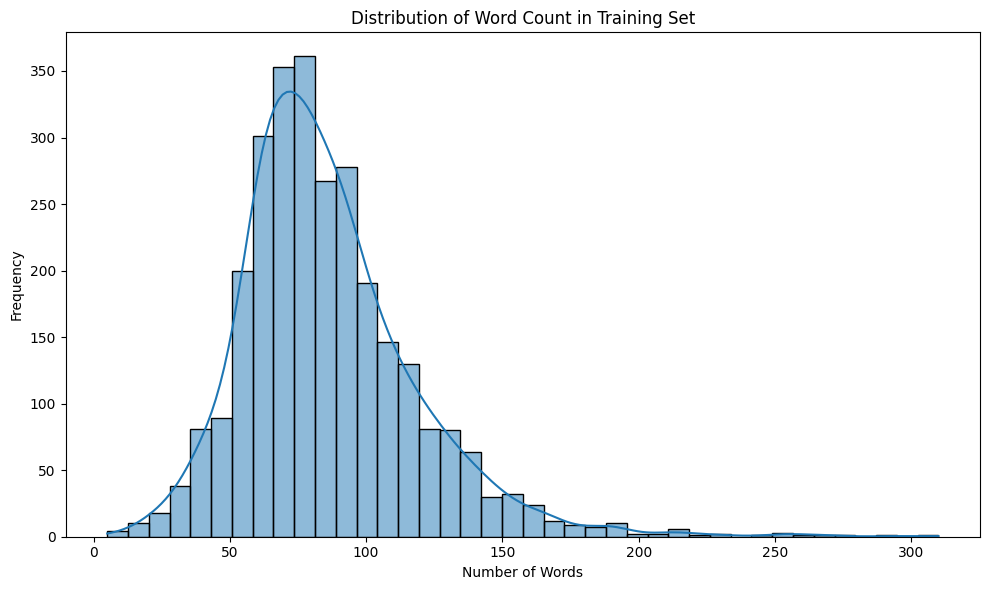

In [169]:
plot_text_length(train_df, "Training Set")

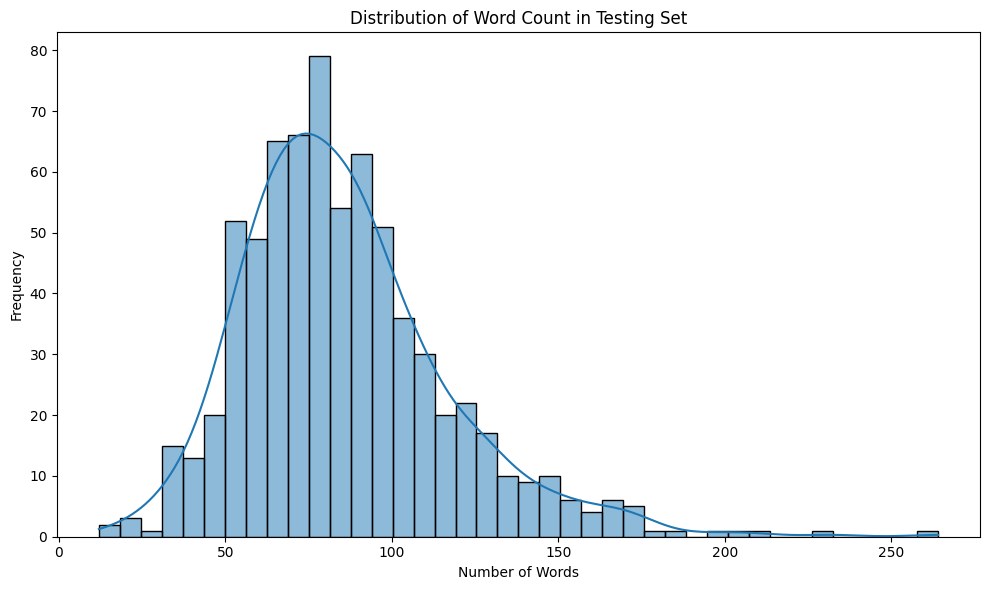

In [170]:
plot_text_length(test_df, "Testing Set")

In [171]:
def find_short_texts(df, min_text_length):
    df = df.copy(deep=True)
    df["text_length"] = df["text"].apply(lambda x: len(x.split()))
    df_short_texts = df[df["text_length"] < min_text_length]
    return df_short_texts.drop(["text_length"], axis=1)

In [172]:
MIN_TEXT_LENGTH = 5       # In terms of approximate number of words (separated by spaces)

In [173]:
find_short_texts(df=train_df, min_text_length=MIN_TEXT_LENGTH)

,subreddit,post_id,sentence_range,text,id,label,confidence,social_timestamp,social_karma,syntax_ari,...,lex_dal_min_pleasantness,lex_dal_min_activation,lex_dal_min_imagery,lex_dal_avg_activation,lex_dal_avg_imagery,lex_dal_avg_pleasantness,social_upvote_ratio,social_num_comments,syntax_fk_grade,sentiment
295,domesticviolence,7idwpv,"(10, 15)",#NAME?,31315,0,0.800000,1512724877,10,1.913846,...,1.2857,1.3333,1.0,1.75970,1.46364,1.96712,0.92,9,1.975077,0.343750
1592,anxiety,7ti69n,"[15, 20]",#NAME?,469,1,0.571429,1517114200,3,9.900000,...,1.0000,1.5000,1.0,1.82062,1.85000,1.77778,1.00,7,3.935556,-0.066667
2190,ptsd,9ut4zv,"[30, 35]",#NAME?,559,1,1.000000,1541543111,9,11.497297,...,1.1429,1.1429,1.0,1.80001,1.75833,1.85932,0.85,9,9.484459,-0.400000
2563,domesticviolence,8m1irj,"(15, 20)",#NAME?,29201,0,0.800000,1527252930,23,6.356558,...,1.0000,1.1250,1.0,1.66671,1.56279,1.95929,1.00,4,6.422609,0.220833


In [174]:
find_short_texts(df=test_df, min_text_length=MIN_TEXT_LENGTH)

,id,subreddit,post_id,sentence_range,text,label,confidence,social_timestamp,social_karma,syntax_ari,...,lex_dal_min_pleasantness,lex_dal_min_activation,lex_dal_min_imagery,lex_dal_avg_activation,lex_dal_avg_imagery,lex_dal_avg_pleasantness,social_upvote_ratio,social_num_comments,syntax_fk_grade,sentiment


### Readability and Sentiment, By Stress Label

In [175]:
def plot_tone_against_sentiment_by_label(df, df_name):
    fig, ax = plt.subplots(figsize=(10, 6))

    # scatter plot by label
    sns.scatterplot(
        data=df,
        x="sentiment",
        y="lex_liwc_Tone",
        hue="label",
        palette={0: "#4C72B0", 1: "#DD8452"},
        alpha=0.7
    )

    # set title, axes and legend
    plt.title(f"Tone and Sentiment of Text, By Stress Label ({df_name})")
    ax.set_xlabel("Sentiment Score")
    ax.set_ylabel("LIWC Tone")
    ax.legend(title="Label")

    # edit x axis
    ax.set_xlim(-1, 1)
    ax.xaxis.set_major_locator(mticker.MultipleLocator(0.2))
    
    # edit y axis
    ax.set_ylim(0, 100)
    ax.yaxis.set_major_locator(mticker.MultipleLocator(10))
    
    plt.tight_layout()

    # save plot
    plt.savefig(os.path.join(EDA_FOLDER_PATH, f"tone_sentiment_by_label_{df_name.lower()}.png"))

    plt.show()

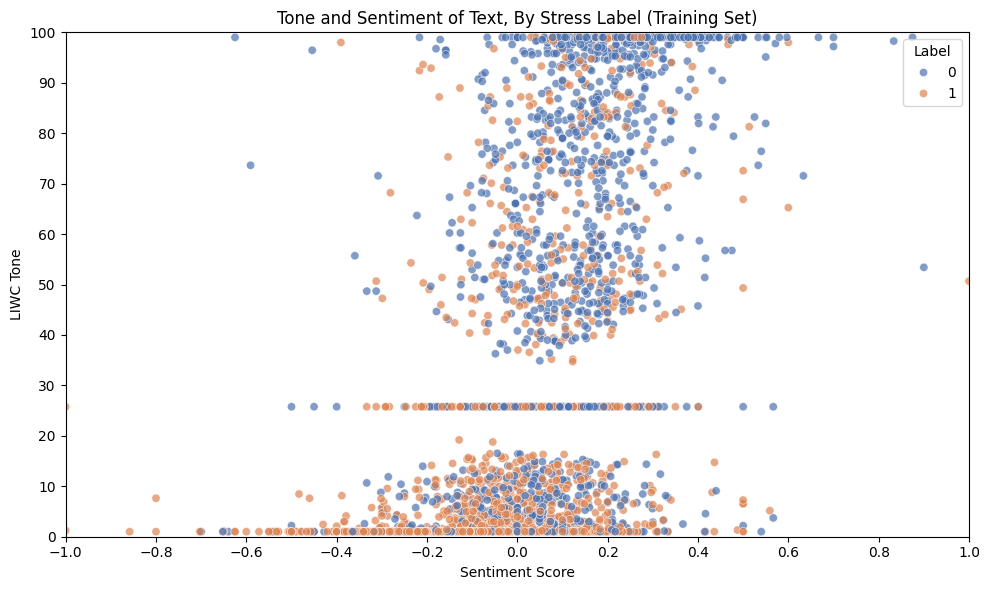

In [176]:
plot_tone_against_sentiment_by_label(train_df, "Training Set")

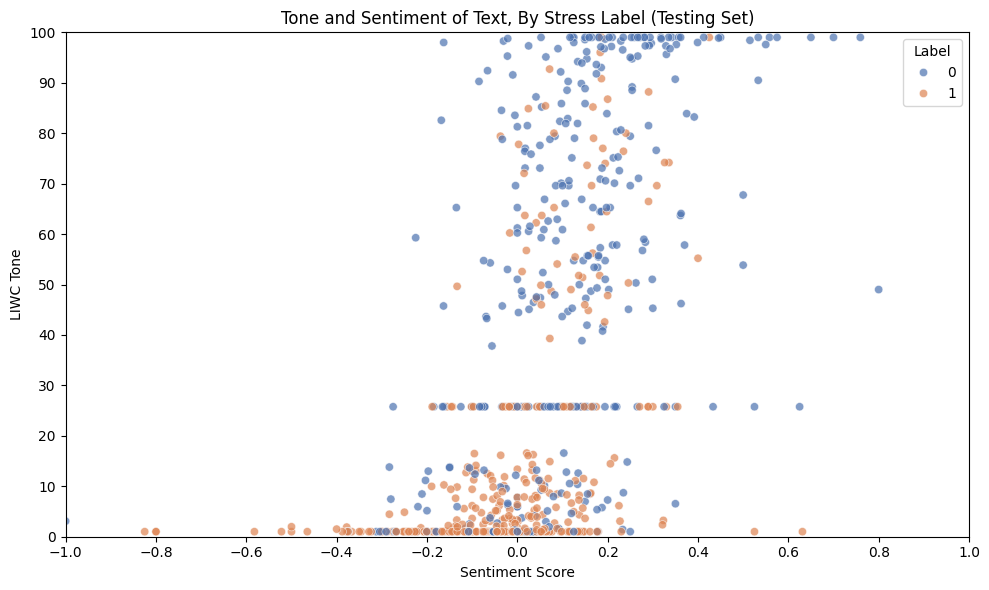

In [177]:
plot_tone_against_sentiment_by_label(test_df, "Testing Set")

## Data Processing

### Choose Columns and Rows

In [178]:
def drop_columns(df):
    return df.drop([
        "subreddit",
        "sentence_range",
        "id",
        "confidence",
        "social_timestamp",
        "social_karma"
    ], axis=1)

def remove_short_texts(df):
    df = df.copy()
    df["num_tokens"] = df["text"].str.split().str.len()
    df = df[df["num_tokens"] >= MIN_TEXT_LENGTH]
    df = df.drop(["num_tokens"], axis=1)

    return df    

In [179]:
train_df_processed = remove_short_texts(drop_columns(train_df))
test_df_processed = remove_short_texts(drop_columns(test_df))

### Create Features and Labels

In [180]:
MODEL_NAME = "google-bert/bert-base-cased"

In [181]:
def tokenise_dataframe(df, tokeniser_name, text_column="text"):
    tokeniser = AutoTokenizer.from_pretrained(tokeniser_name)

    encodings = tokeniser(
        df[text_column].tolist(),
        padding="max_length",
        truncation=True,
        return_tensors="pt"
    )

    encodings = {k: v.to(DEVICE) for k, v in encodings.items()}
    return encodings

def get_embeddings(df, model_name, batch_size=32):
    model = AutoModelForTextEncoding.from_pretrained(model_name).to(DEVICE)

    all_embeddings = list()
    with torch.no_grad():
        for i in range(0, len(df), batch_size):
            batch_texts = df[i: i + batch_size]
            encodings = tokenise_dataframe(batch_texts, model_name)
            inputs = {k: v.to(DEVICE) for k, v in encodings.items()}
            outputs = model(**inputs)
            cls_embeddings = outputs.last_hidden_state[:, 0, :]
    
            all_embeddings.append(cls_embeddings.cpu())

            torch.cuda.empty_cache()

            print(f"Finished getting embeddings for i = {i}")
            
    embedding_features = torch.cat(all_embeddings).numpy()
    embedding_cols = [f"cls_{i}" for i in range(embedding_features.shape[1])]
    embedding_df = pd.DataFrame(embedding_features, columns=embedding_cols)

    embedding_df["label"] = df["label"].values
    
    return embedding_df

In [182]:
def get_features_and_labels(df, is_for_bert_encoding):
    if is_for_bert_encoding:
        features_and_labels = get_embeddings(df, MODEL_NAME)
    
    else:
        features_and_labels = df.drop(["text"], axis=1)

    features_and_labels["label"] = features_and_labels.pop("label")
    
    return features_and_labels

In [183]:
train_df_processed_bert = get_features_and_labels(train_df_processed, is_for_bert_encoding=True)
test_df_processed_bert = get_features_and_labels(test_df_processed, is_for_bert_encoding=True)

train_df_processed_liwc = get_features_and_labels(train_df_processed, is_for_bert_encoding=False)
test_df_processed_liwc = get_features_and_labels(test_df_processed, is_for_bert_encoding=False)

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: google-bert/bert-base-cased
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
cls.seq_relationship.weight                | UNEXPECTED |  | 
cls.predictions.transform.dense.weight     | UNEXPECTED |  | 
cls.predictions.bias                       | UNEXPECTED |  | 
cls.predictions.transform.dense.bias       | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED |  | 
cls.seq_relationship.bias                  | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Finished getting embeddings for i = 0
Finished getting embeddings for i = 32
Finished getting embeddings for i = 64
Finished getting embeddings for i = 96
Finished getting embeddings for i = 128
Finished getting embeddings for i = 160
Finished getting embeddings for i = 192
Finished getting embeddings for i = 224
Finished getting embeddings for i = 256
Finished getting embeddings for i = 288
Finished getting embeddings for i = 320
Finished getting embeddings for i = 352
Finished getting embeddings for i = 384
Finished getting embeddings for i = 416
Finished getting embeddings for i = 448
Finished getting embeddings for i = 480
Finished getting embeddings for i = 512
Finished getting embeddings for i = 544
Finished getting embeddings for i = 576
Finished getting embeddings for i = 608
Finished getting embeddings for i = 640
Finished getting embeddings for i = 672
Finished getting embeddings for i = 704
Finished getting embeddings for i = 736
Finished getting embeddings for i = 768
Finis

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: google-bert/bert-base-cased
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
cls.seq_relationship.weight                | UNEXPECTED |  | 
cls.predictions.transform.dense.weight     | UNEXPECTED |  | 
cls.predictions.bias                       | UNEXPECTED |  | 
cls.predictions.transform.dense.bias       | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED |  | 
cls.seq_relationship.bias                  | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Finished getting embeddings for i = 0
Finished getting embeddings for i = 32
Finished getting embeddings for i = 64
Finished getting embeddings for i = 96
Finished getting embeddings for i = 128
Finished getting embeddings for i = 160
Finished getting embeddings for i = 192
Finished getting embeddings for i = 224
Finished getting embeddings for i = 256
Finished getting embeddings for i = 288
Finished getting embeddings for i = 320
Finished getting embeddings for i = 352
Finished getting embeddings for i = 384
Finished getting embeddings for i = 416
Finished getting embeddings for i = 448
Finished getting embeddings for i = 480
Finished getting embeddings for i = 512
Finished getting embeddings for i = 544
Finished getting embeddings for i = 576
Finished getting embeddings for i = 608
Finished getting embeddings for i = 640
Finished getting embeddings for i = 672
Finished getting embeddings for i = 704


In [184]:
train_df_processed_bert.head()

,cls_0,cls_1,cls_2,cls_3,cls_4,cls_5,cls_6,cls_7,cls_8,cls_9,...,cls_759,cls_760,cls_761,cls_762,cls_763,cls_764,cls_765,cls_766,cls_767,label
0,0.531697,0.325520,0.204317,-0.174423,-0.041935,0.014186,0.104426,-0.155956,-0.399652,-0.958083,...,0.019859,-0.194712,0.129987,-0.060495,0.065956,0.133252,-0.125721,0.068329,0.044005,1
1,0.547921,-0.084257,-0.249329,-0.091157,-0.054705,0.232112,0.269716,-0.081781,-0.043917,-0.990457,...,-0.035050,-0.149997,-0.219658,0.192631,0.013489,0.151914,-0.196105,0.213651,0.446670,0
2,0.466684,0.361257,-0.176716,-0.186033,-0.294517,0.016399,0.251710,-0.025040,0.078968,-1.388114,...,0.207081,-0.332115,0.313552,-0.044047,0.182538,0.020334,-0.271231,0.248994,-0.072288,1
3,0.690333,-0.004333,-0.405099,-0.094038,-0.234026,-0.137288,0.484116,-0.073898,-0.217052,-1.206729,...,0.301981,-0.166751,0.294863,0.136605,0.358522,-0.045333,-0.289477,0.131599,-0.225148,1
4,0.611001,0.016004,-0.345124,-0.221886,-0.365712,-0.109200,0.180666,-0.167158,0.080151,-1.227930,...,0.291518,-0.248831,0.083036,0.275619,0.329042,0.025625,-0.107659,-0.007032,-0.036759,1


In [185]:
test_df_processed_bert.head()

,cls_0,cls_1,cls_2,cls_3,cls_4,cls_5,cls_6,cls_7,cls_8,cls_9,...,cls_759,cls_760,cls_761,cls_762,cls_763,cls_764,cls_765,cls_766,cls_767,label
0,0.339393,0.411175,-0.164933,-0.235934,0.050873,-0.001968,0.065735,-0.208145,-0.125898,-0.918084,...,-0.006552,-0.111946,0.011021,0.120779,0.291534,-0.111926,0.004632,0.065132,0.013648,0
1,0.689114,0.037972,0.022245,-0.318889,-0.385325,-0.390239,0.564624,-0.087873,0.000817,-1.112869,...,0.081650,-0.069878,-0.169105,0.037631,0.268997,-0.012531,-0.156415,0.021908,-0.026465,0
2,0.677657,0.237848,-0.068995,-0.038220,-0.176345,0.043698,0.065858,-0.137975,-0.224507,-1.044048,...,0.300861,-0.198682,0.061789,0.023121,0.073073,-0.053751,-0.389938,0.054129,0.050681,1
3,0.499441,0.397153,0.003467,-0.187921,-0.202831,-0.082660,0.230959,0.077255,-0.021949,-1.008633,...,0.272699,-0.058623,-0.090020,0.023549,0.393212,0.058483,-0.202756,0.042352,-0.224447,1
4,0.766698,0.288677,-0.091271,-0.054787,-0.026643,-0.180228,0.201435,-0.139327,-0.142901,-1.235818,...,0.191683,0.086170,0.012458,0.084685,0.146372,0.102607,-0.308993,0.080905,-0.209653,0


In [186]:
train_df_processed_liwc.head()

,post_id,syntax_ari,lex_liwc_WC,lex_liwc_Analytic,lex_liwc_Clout,lex_liwc_Authentic,lex_liwc_Tone,lex_liwc_WPS,lex_liwc_Sixltr,lex_liwc_Dic,...,lex_dal_min_activation,lex_dal_min_imagery,lex_dal_avg_activation,lex_dal_avg_imagery,lex_dal_avg_pleasantness,social_upvote_ratio,social_num_comments,syntax_fk_grade,sentiment,label
0,8601tu,1.806818,116,72.64,15.04,89.26,1.00,29.00,12.93,87.07,...,1.1250,1.0,1.77000,1.52211,1.89556,0.86,1,3.253573,-0.002742,1
1,8lbrx9,9.429737,109,79.08,76.85,56.75,98.18,27.25,21.10,87.16,...,1.0000,1.0,1.69586,1.62045,1.88919,0.65,2,8.828316,0.292857,0
2,9ch1zh,7.769821,167,33.80,76.38,86.24,25.77,33.40,17.37,91.02,...,1.1429,1.0,1.83088,1.58108,1.85828,0.67,0,7.841667,0.011894,1
3,7rorpp,2.667798,273,2.98,15.25,95.42,79.26,54.60,8.06,98.90,...,1.1250,1.0,1.75356,1.52114,1.98848,0.50,5,4.104027,0.141671,1
4,9p2gbc,7.554238,89,32.22,28.71,84.01,1.00,17.80,31.46,88.76,...,1.1250,1.0,1.77644,1.64872,1.81456,1.00,1,7.910952,-0.204167,1


In [187]:
test_df_processed_liwc.head()

,post_id,syntax_ari,lex_liwc_WC,lex_liwc_Analytic,lex_liwc_Clout,lex_liwc_Authentic,lex_liwc_Tone,lex_liwc_WPS,lex_liwc_Sixltr,lex_liwc_Dic,...,lex_dal_min_activation,lex_dal_min_imagery,lex_dal_avg_activation,lex_dal_avg_imagery,lex_dal_avg_pleasantness,social_upvote_ratio,social_num_comments,syntax_fk_grade,sentiment,label
0,7nu7as,-1.238793,55,2.82,57.22,55.41,5.95,11.00,7.27,94.55,...,1.2000,1.0,1.65864,1.32245,1.80264,0.63,62,-0.148707,0.000000,0
1,680i6d,7.684583,72,64.56,50.00,31.19,92.40,14.40,25.00,84.72,...,1.1250,1.0,1.69133,1.69180,1.97249,1.00,2,7.398222,-0.065909,0
2,8eeu1t,2.360408,148,14.79,75.05,62.88,16.15,21.14,10.81,94.59,...,1.0000,1.0,1.70974,1.52985,1.86108,1.00,8,3.149288,-0.036818,1
3,8d28vu,5.997000,100,32.13,38.19,79.76,12.51,20.00,9.00,92.00,...,1.3000,1.0,1.72615,1.52000,1.84909,1.00,7,6.606000,-0.066667,1
4,7r1e85,4.649418,78,4.96,50.00,71.23,89.84,15.60,21.79,96.15,...,1.1429,1.0,1.75642,1.43582,1.91725,0.84,70,4.801869,0.141667,0


In [194]:
train_df_processed_bert["label"].value_counts(normalize=True)

label
1    0.524347
0    0.475653
Name: proportion, dtype: float64

In [195]:
test_df_processed_bert["label"].value_counts(normalize=True)

label
1    0.516084
0    0.483916
Name: proportion, dtype: float64

In [196]:
train_df_processed_liwc["label"].value_counts(normalize=True)

label
1    0.524347
0    0.475653
Name: proportion, dtype: float64

In [197]:
test_df_processed_liwc["label"].value_counts(normalize=True)

label
1    0.516084
0    0.483916
Name: proportion, dtype: float64

In [200]:
# save these dataframes
DATA_PATH = "data"
os.makedirs(DATA_PATH, exist_ok=True)

train_df_processed_bert.to_csv(os.path.join(DATA_PATH, "train_bert.csv"), index=False)
test_df_processed_bert.to_csv(os.path.join(DATA_PATH, "test_bert.csv"), index=False)
train_df_processed_liwc.to_csv(os.path.join(DATA_PATH, "train_liwc.csv"), index=False)
test_df_processed_liwc.to_csv(os.path.join(DATA_PATH, "test_liwc.csv"), index=False)

## Training Last-Stage Classifiers

In [193]:
def display_and_save_cm(cm: np.ndarray, filename: str) -> None:
    # make heat map of confusion matrix
    plt.figure(figsize=(8, 6))
    sns.set_theme(font_scale=0.8)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

    # save this heat map
    cm_file_path = os.path.join(os.path.normpath(os.path.join("..", "sentiment_analysis_eval_results")), f"{filename}_cm.png")
    plt.savefig(cm_file_path, bbox_inches="tight")

    # display heat map
    print("Confusion Matrix:")
    plt.show()


def train_and_eval_classifier(model: ClassifierMixin, X_train: np.ndarray, y_train: np.ndarray, X_test: np.ndarray, y_test: np.ndarray, filename: str) -> ClassifierMixin:
    # train the model
    model.fit(X_train, y_train)

    # predict on test set
    y_preds = model.predict(X_test)

    # calculate evaluation metrics
    acc = accuracy_score(y_test, y_preds)
    precision = precision_score(y_test, y_preds, pos_label=1)
    recall = recall_score(y_test, y_preds, pos_label=1)
    f1 = f1_score(y_test, y_preds, pos_label=1)
    cm = confusion_matrix(y_test, y_preds)

    # print evaluation metrics
    print(f"Accuracy: {round(acc * 100, 1)}%")
    print(f"Precision: {round(precision * 100, 1)}%")
    print(f"Recall: {round(recall * 100, 1)}%")
    print(f"F1 score: {round(f1 * 100, 1)}%")

    # display and save confusion matrix
    display_and_save_cm(cm=cm, filename=filename)
    
    # save fitted model
    with open(os.path.normpath(os.path.join("..", "sentiment_analysis_outputs", f"{filename}_model.pkl")), "wb") as f:
        pickle.dump(model, f)

    return model

NameError: name 'np' is not defined